In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append("src/")
from src.transport_model import TransportModel, get_data_loaders, get_model_inputs, ModelEnsemble
from src.db_handler import DB_handler
import os
import torch
from src.constants import *
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
db = DB_handler("data/db6june.feather")
#norms = db.get_norm_parameters(NORM_ZSCORE)
#db.data = db[db[SHOT] != 35894]
#train_dataloader, test_dataloader = get_data_loaders(db, batch_size=512, test_size=0.1)

In [5]:
ensemble = ModelEnsemble(10)
ensemble2 = ModelEnsemble(10)
#ensemble.set_norm(db.get_norm_parameters(NORM_ZSCORE))
ensemble.load("ensemble_without_35894")
ensemble2.load("db6june_with_ions_40epochs")

In [4]:
#loss = ensemble.train_epochs(train_dataloader, 40)

In [5]:
#ensemble.save("ensemble_without_35894")

In [8]:
shot_data = db[db[SHOT] == 35894]
shot_data = shot_data[(shot_data[TIME] > 2.5) & (shot_data[TIME] < 3.5)]

In [9]:
time_base = shot_data[TIME].values
time_base = time_base.reshape((-1, 12))
time_base = time_base[:, 0]

rho_base = shot_data[RHO].values
rho_base = rho_base.reshape((-1, 12))
rho_base[0]

te = shot_data[ELECTRON_TEMP].values 
te = te.reshape((-1, 12))

chi_e = shot_data[CHI_ELECTRON].values
chi_e = chi_e.reshape((-1, 12))

te_interpol = np.zeros((time_base.shape[0], 2))
rho_points = np.array([0.6, 0.8])
chi_e_interpol = np.zeros((time_base.shape[0], 2))

for tidx, t in enumerate(time_base):
    te_interpol[tidx, :] = interp1d(rho_base[tidx], te[tidx])(rho_points)
    chi_e_interpol[tidx, :] = interp1d(rho_base[tidx], chi_e[tidx])(rho_points)

In [10]:
model_inputs = shot_data[MODEL_INPUTS].values
model_inputs = model_inputs.reshape((-1, 12, 20))

model_inputs_interp = np.zeros((time_base.shape[0], 2, 20))

for tidx, t in enumerate(time_base):
    inputs_at_t = model_inputs[tidx]
    for param_idx in range(len(MODEL_INPUTS)):
        params_profile = inputs_at_t[:, param_idx]
        model_inputs_interp[tidx, :, param_idx] = interp1d(rho_base[tidx], params_profile)(rho_points)
        

In [11]:
# get absolute values of q and shear
model_inputs_interp[:, :, 6:8] = np.abs(model_inputs_interp[:, :, 6:8])

In [12]:
fits_rho_06 = []
fits_rho_08 = []

fits_rho_06_2 = []
fits_rho_08_2 = []

for input in model_inputs_interp:
    input_06 = torch.tensor(input[0, :].astype(np.float32))
    input_08 = torch.tensor(input[1, :].astype(np.float32))
    fits_rho_06.append(ensemble.predict(input_06))
    fits_rho_08.append(ensemble.predict(input_08))
    fits_rho_06_2.append(ensemble2.predict(input_06))
    fits_rho_08_2.append(ensemble2.predict(input_08))

fits_rho_06 = np.array(fits_rho_06)    
fits_rho_08 = np.array(fits_rho_08)

fits_rho_06_2 = np.array(fits_rho_06_2)    
fits_rho_08_2 = np.array(fits_rho_08_2)

In [13]:
fits_rho_06_elec_mean = fits_rho_06.mean(axis=1)[:, 0]
fits_rho_06_elec_std = fits_rho_06.std(axis=1)[:, 0]

fits_rho_08_elec_mean = fits_rho_08.mean(axis=1)[:, 0]
fits_rho_08_elec_std = fits_rho_08.std(axis=1)[:, 0]


fits_rho_06_elec_mean_2 = fits_rho_06_2.mean(axis=1)[:, 0]
fits_rho_06_elec_std_2 = fits_rho_06_2.std(axis=1)[:, 0]

fits_rho_08_elec_mean_2 = fits_rho_08_2.mean(axis=1)[:, 0]
fits_rho_08_elec_std_2 = fits_rho_08_2.std(axis=1)[:, 0]

In [14]:
plt.plot(time_base, fits_rho_06_elec_mean)
plt.fill_between(time_base, fits_rho_06_elec_mean - fits_rho_06_elec_std,
                            fits_rho_06_elec_mean + fits_rho_06_elec_std, 
                            alpha=0.15)

plt.plot(time_base, fits_rho_08_elec_mean)
plt.fill_between(time_base, fits_rho_08_elec_mean - fits_rho_08_elec_std,
                            fits_rho_08_elec_mean + fits_rho_08_elec_std, 
                            alpha=0.15)
plt.plot(time_base, chi_e_interpol)

In [15]:
plt.plot(time_base, chi_e_interpol)

In [21]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 10))

ax1.plot(time_base, chi_e_interpol[:, 0])
ax1.set_ylabel(r"$\chi_e$ [m²/s]")

ax1.plot(time_base, fits_rho_06_elec_mean, "--", color="tab:blue")
ax1.fill_between(time_base, fits_rho_06_elec_mean - fits_rho_06_elec_std,
                            fits_rho_06_elec_mean + fits_rho_06_elec_std, 
                            alpha=0.15)
ax1.plot(time_base, chi_e_interpol[:, 1], color="tab:red")
ax1.set_ylabel(r"$\chi_e$ [m²/s]")

ax1.plot(time_base, fits_rho_08_elec_mean, "--", color="tab:red")
ax1.fill_between(time_base, fits_rho_08_elec_mean - fits_rho_08_elec_std,
                            fits_rho_08_elec_mean + fits_rho_08_elec_std, 
                            alpha=0.15, color="tab:red")


ax2.plot(time_base, chi_e_interpol[:, 0])
ax2.set_ylabel(r"$\chi_e$ [m²/s]")

ax2.plot(time_base, fits_rho_06_elec_mean_2, "--", color="tab:blue")
ax2.fill_between(time_base, fits_rho_06_elec_mean_2 - fits_rho_06_elec_std_2,
                            fits_rho_06_elec_mean_2 + fits_rho_06_elec_std_2, 
                            alpha=0.15)

ax2.plot(time_base, chi_e_interpol[:, 1], color="tab:red")
ax2.set_ylabel(r"$\chi_e$ [m²/s]")

ax2.plot(time_base, fits_rho_08_elec_mean_2, "--", color="tab:red")
ax2.fill_between(time_base, fits_rho_08_elec_mean_2 - fits_rho_08_elec_std_2,
                            fits_rho_08_elec_mean_2 + fits_rho_08_elec_std_2, 
                            alpha=0.15, color="tab:red")

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="tab:blue", lw=2),
                Line2D([0], [0], color="tab:red", lw=2),
                Line2D([0], [0], color="black", lw=2),
                Line2D([0], [0], color="black", ls="--", lw=2)]
ax1.legend(custom_lines, [r'$\rho=0.6$', r'$\rho=0.8$', "database", "model (shot excluded)"])
ax2.legend(custom_lines, [r'$\rho=0.6$', r'$\rho=0.8$', "database", "model (shot included)"])


lines = ax3.plot(time_base, te_interpol/1e3, label=[r"$\rho = 0.6$", r"$\rho = 0.8$"])
lines[1].set_color("tab:red")
ax3.set_ylabel(r"$T_e$ [keV]")
ax3.legend()

ax4.plot(shot_data.groupby(TIME).max()[ECRH_POWER]/1e6)
ax4.set_xlabel("time [s]")
ax4.set_ylabel("ECRH power [MW]")

ax1.set_title("Time evolution for 35894")

plt.savefig("../Thesis/Chapters/5-Results/img/time_evolution.png")

In [13]:
data_for_35894_Lmode = db[(db[SHOT] == 35894) & np.isclose(db[TIME], 2.61, 0.001)]
data_for_35894_Hmode = db[(db[SHOT] == 35894) & np.isclose(db[TIME], 3.41, 0.002)]

In [14]:
l_mode_inputs = get_model_inputs(data_for_35894_Lmode)
h_mode_inputs = get_model_inputs(data_for_35894_Hmode)

fits_l_mode = []
for input in l_mode_inputs:
    fits_l_mode.append(ensemble.predict(input))
fits_l_mode = np.array(fits_l_mode)

fits_h_mode = []
for input in h_mode_inputs:
    fits_h_mode.append(ensemble.predict(input))
fits_h_mode = np.array(fits_h_mode)

fits_l_mode_mean = fits_l_mode.mean(axis=1)
fits_l_mode_std = fits_l_mode.std(axis=1)

fits_h_mode_mean = fits_h_mode.mean(axis=1)
fits_h_mode_std = fits_h_mode.std(axis=1)

In [282]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(8, 8), sharey="row")

ax1.plot(data_for_35894_Lmode[RHO], data_for_35894_Lmode[CHI_ELECTRON])
ax1.plot(data_for_35894_Lmode[RHO], fits_l_mode_mean[:, 0], color="tab:red")
ax1.fill_between(data_for_35894_Lmode[RHO], 
         fits_l_mode_mean[:, 0] - fits_l_mode_std[:, 0], 
         fits_l_mode_mean[:, 0] + fits_l_mode_std[:, 0], alpha=0.15, color="tab:red")
ax1.set_ylabel(r"$\chi_e$ [m²/s]")
ax1.set_title("Shot 35894 at 2.61 s")

ax2.plot(data_for_35894_Hmode[RHO], data_for_35894_Hmode[CHI_ELECTRON])
ax2.plot(data_for_35894_Hmode[RHO], fits_h_mode_mean[:, 0], color="tab:red")
ax2.fill_between(data_for_35894_Hmode[RHO], 
         fits_h_mode_mean[:, 0] - fits_h_mode_std[:, 0], 
         fits_h_mode_mean[:, 0] + fits_h_mode_std[:, 0], alpha=0.15, color="tab:red")
ax2.set_title("Shot 35894 at 3.41 s")


ax3.plot(data_for_35894_Lmode[RHO], data_for_35894_Lmode[CHI_ION], label="database")
ax3.plot(data_for_35894_Lmode[RHO], fits_l_mode_mean[:, 1], label="model prediction", color="tab:red")
ax3.fill_between(data_for_35894_Lmode[RHO], 
         fits_l_mode_mean[:, 1] - fits_l_mode_std[:, 1], 
         fits_l_mode_mean[:, 1] + fits_l_mode_std[:, 1], alpha=0.15, color="tab:red")
ax3.set_ylabel(r"$\chi_i$ [m²/s]")
ax3.legend()


ax4.plot(data_for_35894_Hmode[RHO], data_for_35894_Hmode[CHI_ION])
ax4.plot(data_for_35894_Hmode[RHO], fits_h_mode_mean[:, 1], color="tab:red")
ax4.fill_between(data_for_35894_Hmode[RHO], 
         fits_h_mode_mean[:, 1] - fits_h_mode_std[:, 1], 
         fits_h_mode_mean[:, 1] + fits_h_mode_std[:, 1], alpha=0.15, color="tab:red")
ax4.legend()

ax5.plot(data_for_35894_Lmode[RHO], data_for_35894_Lmode[ELECTRON_TEMP]/1e3, label="Electrons")
ax5.plot(data_for_35894_Lmode[RHO], data_for_35894_Lmode[ION_TEMP]/1e3, label="Ions", color="tab:red")
ax5.set_ylabel("T [keV]")
ax5.legend()
ax5.set_xlabel(r"$\rho$")

ax6.plot(data_for_35894_Hmode[RHO], data_for_35894_Hmode[ELECTRON_TEMP]/1e3)
ax6.plot(data_for_35894_Hmode[RHO], data_for_35894_Hmode[ION_TEMP]/1e3, color="tab:red")
ax6.set_xlabel(r"$\rho$")

plt.suptitle("Profiles for Shot 35894")
plt.tight_layout()
plt.savefig("../Thesis/Chapters/5-Results/img/baseline_fits.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [15]:
def te_modifier(te, rhobase, a=1):
    modifier = a * (rhobase.max()-rhobase)/(rhobase.max()-rhobase.min())
    return (1+modifier)*te

def te_scale_modifier(te, te_mod, te_scale, rhobase):
    grad = np.gradient(te, rhobase)
    grad_mod = np.gradient(te_mod, rhobase)
    return te_scale * (grad_mod/grad) * (te/te_mod)

def t_ratio_modifier(te, te_mod, t_ratio):
    return (te_mod/te)*t_ratio

In [54]:

data_mod05 = data_for_35894_Lmode.copy()
data_mod05[T_RATIO] *= 1
data_mod05[Q_SAFETY] *= 1.5

rhobase = data_mod05[RHO]

inputs_mod05 = get_model_inputs(data_mod05)
fits_mod05 = []
for input in inputs_mod05:
    fits_mod05.append(ensemble.predict(input))
fits_mod05 = np.array(fits_mod05)

fits_mod05_mean = fits_mod05.mean(axis=1)
fits_mod05_std = fits_mod05.std(axis=1)

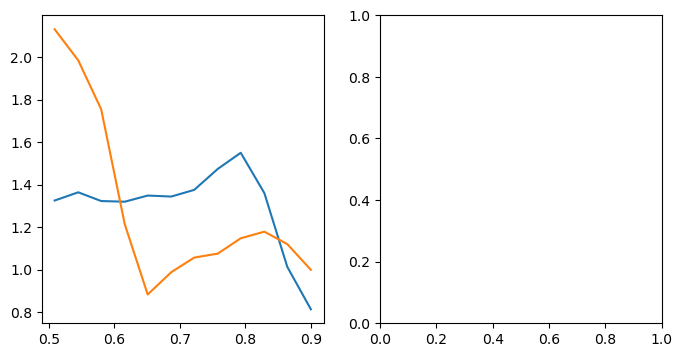

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.plot(rhobase, fits_l_mode_mean[:, 0])
ax1.plot(rhobase, fits_mod05_mean[:, 0])